## FAIR USE POLICY
**Please do not leave your Jupyter lab server idle for extended periods of time.** The Jupyter process, active Python kernels, and especially running Spark contexts, claim a minimum amount of cluster resources. These add up and will get starve resources of others eventually. Leaving your environment idle for a few hours (e.g., over lunch) is fine. But letting it idle overnight or for multiple days in which you are not actively using the cluster is not. You can kill the server from your SSH session, by pressing ctrl+c repeatedly, or by selecting *File->Shutdown* from the menu.

### Imports

In [145]:
#!pip install -U scikit-learn
#!pip install wordcloud

In [1]:
import os
import time
from datetime import datetime, timedelta, date
import pprint

import collections
import numpy as np
import pandas as pd
import subprocess

import pyspark
import pyspark.sql.functions as F

# Find Spark
import findspark
findspark.init()


from datetime import datetime, timedelta, date
import os
import pandas as pd
import subprocess
import re
import pyarrow as pa
import copy

from string import digits

import pyspark
from pyspark.sql import *  
from pyspark.sql.functions import *
from pyspark.sql.types import *
from sparknlp.annotator import LemmatizerModel
from sparknlp.pretrained import PretrainedPipeline


import sparknlp 
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from nltk.corpus import stopwords
from pyspark.sql.functions import expr

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import ChainMap

from IPython.core.display import HTML
import nltk
import sys
import gc
#nltk.download('words')
#nltk.download('stopwords')

#### Create Spark Configuration

In [2]:
# Create a SparkConf
APP_NAME = "apwg-sparknlp-app"

spark_conf = pyspark.SparkConf().setAppName(APP_NAME).setMaster("yarn").set(
    "spark.submit.deployMode", "client"
).set("spark.sql.parquet.binaryAsString", "true"
).set("spark.dynamicAllocation.maxExecutors", "16"
).set("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp-spark24_2.11:3.0.0"
).set("spark.sql.debug.maxToStringFields", "2000"
).set("spark.executor.memory", "6G")

#### Start SparkContext
1. This may take a minute to complete
2. You should not (and cannot) start two Spark contexts. If you accidentally run this cell twice or get stuck somehow, restart your Python kernel from the menu above.
3. Please **stop your Spark context** when idling for extended periods of time (see code at bottom of notebook)

In [3]:
print("[{}] Starting Spark context.".format(datetime.now().replace(microsecond=0)))

# SparkContext
sc = pyspark.SparkContext(conf=spark_conf)

# SQLContext
sqlc = pyspark.SQLContext(sc)

[2021-04-20 16:54:39] Starting Spark context.


### Your code below

In [4]:
APWG_CLEAN_DATA_CONVERTED_BASE = "PATH TO DATA-RECORDS"
INTEREST_DATE_START = datetime(2017, 12, 18)
INTEREST_DATE_END   = datetime(2019, 8, 16)

# Read JSON files into Spark DF
clean_mails_df = sqlc.read.json(APWG_CLEAN_DATA_CONVERTED_BASE, multiLine=True).withColumn(
    "parsed_date", F.from_unixtime(F.col("date_received")).cast("date")
).filter(
    # Filter date range of interest
    (F.col("parsed_date") >= INTEREST_DATE_START.date().isoformat()) &
    (F.col("parsed_date") <= INTEREST_DATE_END.date().isoformat())
)


In [5]:
#filter emails in english language
original_df = clean_mails_df
eng_df = original_df.filter(original_df.language == "english")
original_df = eng_df.select('id','email_raw_body')

In [7]:
#to use Spark NLP functionality such as Normalizer or Tokenizer, we have to transform our data to annotation format that Spark NLP understands.
#DocumentAssembler takes care of this. It creates the annotation from raw text data allowing other Spark NLP annotators to be used further on this data.
documentAssembler = DocumentAssembler().setInputCol('email_raw_body').setOutputCol('document')


#tokenize our data — split sentences into words
tokenizer = Tokenizer()\
     .setInputCols(['document'])\
     .setOutputCol('tokenized')\
     .setMinLength(3)


#clean the data and perform lowercasing
cleanup = ["[^A-Za-z]"]
#cleanup = ["([^a-z\s])|((^|\s)[a-z]{1,4}(\s|$))"]
normalizer = Normalizer()\
     .setInputCols(['tokenized'])\
     .setOutputCol('normalized')\
     .setLowercase(True)\
     .setCleanupPatterns(cleanup)


#lemmatization — bringing all words in the data to its lemma (base form)
lemmatizer = LemmatizerModel.pretrained()\
     .setInputCols(['normalized'])\
     .setOutputCol('lemmatized')


eng_stopwords = stopwords.words('english')
#filter stop words
stopwords_cleaner = StopWordsCleaner()\
     .setInputCols(['lemmatized'])\
     .setOutputCol('no_stop')\
     .setStopWords(eng_stopwords)


finisher = Finisher() \
     .setInputCols(['no_stop'])


pipeline = Pipeline() \
     .setStages([documentAssembler,
                 tokenizer,
                 normalizer,
                 lemmatizer,
                 stopwords_cleaner,
                 finisher])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [8]:
processed_df = pipeline.fit(original_df).transform(original_df)

In [9]:
processed_df = processed_df.drop('email_raw_body')

In [10]:
wordlist = set(nltk.corpus.words.words())
@F.udf('array<string>')
def remove_words(words):
    return [word for word in words if word in wordlist]
    #return [word for word in words if word in nltk.corpus.words.words()]

In [11]:
processed_df = processed_df.withColumn('words_final', remove_words('finished_no_stop')).persist()
processed_df = processed_df.drop('finished_no_stop')

In [14]:
new_processed_df = processed_df

In [15]:
#TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
# tf_num = Number of times term t appears in a document
# tf_den = Total number of terms in the document

# add tf_den to new_processed_df

new_processed_df = new_processed_df.withColumn('tf_den', F.size(F.col('words_final')))

In [16]:
explode_df = new_processed_df.select(new_processed_df.id,explode(new_processed_df.words_final).alias("words")).persist()

In [22]:
#gc.collect()
explode_df.select("id", "words").show(10)

+-------+-------+
|     id|  words|
+-------+-------+
|2563461|  reply|
|2563461|forward|
|2563461|message|
|2563461|   date|
|2563461|    mar|
|2563461|subject|
|2563461|  never|
|2563461|    pay|
|2563461|another|
|2563461|    car|
+-------+-------+
only showing top 10 rows



In [17]:
explode_df = explode_df.filter(length(explode_df.words) > '3').persist()

In [18]:
#groupby words on id and count id -> for example, count no. of times 'thanks' appear in id 2199874 -> which is 4 so tf_num will be 4 for 'thanks'

#partition_df = explode_df.repartition(20).persist()
tf_df = explode_df.groupBy("id","words").agg(count("id").alias("tf_num"))

In [19]:
new_processed_df = new_processed_df.select("id", "tf_den")

#joining new_processed_df with tf_df

#try using cache or persist before join
new_processed_df = tf_df.join(new_processed_df, on=['id'], how='inner')

In [20]:
# adding tf_num/tf_den in new_processed_df

new_processed_df = new_processed_df.withColumn("TF", round((F.col("tf_num") / F.col("tf_den")),3))

In [21]:
#IDF = (Total number of documents)/(Number of documents containing the word)
# idf_num = Total number of documents
# idf_den= Number of documents containing the word


idf_df = explode_df.groupby(['words'])
idf_df = idf_df.agg(F.countDistinct(col('id')).alias('idf_den'))

In [22]:
#adding total email count in the data-range
email_count = original_df.count()
new_processed_df = new_processed_df.withColumn('idf_num', lit(email_count))

In [24]:
#joining new_processed_df with idf_df -> tf_idf
tf_idf = new_processed_df.join(idf_df, on=['words'], how='inner')

In [25]:
# adding idf_num/idf_den in tf_idf

tf_idf = tf_idf.withColumn("IDF", round(log(F.col("idf_num") / F.col("idf_den")),3))

In [26]:
# add TF-IDF in tf_idf
tf_idf = tf_idf.withColumn("TF_IDF", round((F.col("TF") * F.col("IDF")),3))

In [27]:
final_df = tf_idf

In [28]:
final_df = final_df.drop('id', 'tf_num', 'tf_den', 'idf_num', 'idf_den')
final_df = final_df.dropDuplicates(['words', 'TF', 'IDF'])
#final_df = final_df.filter(length(new_processed_df.words) > '3')
w = Window.partitionBy('words')
final_df = final_df.withColumn('max_tf_idf', F.max('TF_IDF').over(w))\
    .where(F.col('TF_IDF') == F.col('max_tf_idf'))\
    .drop('max_tf_idf')

In [35]:
plot_df = final_df

plot_df = plot_df.orderBy(plot_df['TF_IDF'].desc())
plot_df = plot_df.limit(200)

In [37]:
plot_df.show(200)

+---------------+-----+------+------+
|          words|   TF|   IDF|TF_IDF|
+---------------+-----+------+------+
|    serendipity|  1.0| 9.545| 9.545|
|           blob|  1.0|  9.11|  9.11|
|           bibb|  1.0|  9.11|  9.11|
|           acca|0.849| 7.606| 6.457|
|   unsubscribed|  1.0| 5.391| 5.391|
|          blanc|  0.6| 8.923| 5.354|
|          penny|0.805|  6.43| 5.176|
|           hack|  1.0| 4.754| 4.754|
|       absolute|  1.0| 4.366| 4.366|
|      developer|0.772| 5.628| 4.345|
|          penna|  0.4|10.238| 4.095|
|          tammy|0.535| 7.567| 4.048|
|         litter|  0.5| 7.945| 3.973|
|        presser|0.364|10.844| 3.947|
|        general|  1.0| 3.926| 3.926|
|         portia|  0.4| 9.692| 3.877|
|       subtotal|0.658| 5.814| 3.826|
|         dragon|  0.5| 7.348| 3.674|
|         glazer|0.333|11.027| 3.672|
|           kind|  1.0| 3.658| 3.658|
|          group|  1.0| 3.415| 3.415|
|         script|0.663| 5.111| 3.389|
|           love|  1.0| 3.358| 3.358|
|     invinc

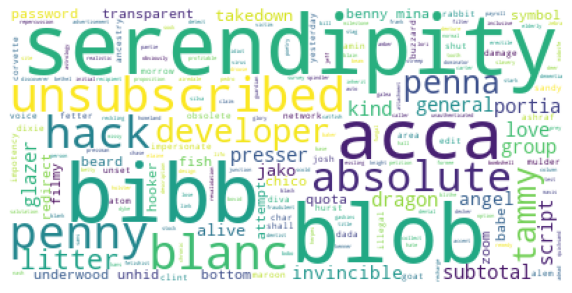

In [38]:
wordcloud = WordCloud(background_color="white")
#map tf_idf with words
#chainMap: dict-like class for creating a single view of multiple mappings
words = dict(ChainMap(*plot_df.select(F.create_map('words', 'TF_IDF')).rdd.map(lambda x: x[0]).collect()))
# {'scorbutically': 1.76, 'punta': 1.76, 'detail': 1.789, 'lafayette': 1.8, 'maya': 1.854, 'prostate': 1.854, 'quot': 1.856, 'mark': 1.949, 'elite': 1.988, 'trade': 2.012, 'write': 2.083}
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(wordcloud.generate_from_frequencies(words))


#### Stop the SparkContext
note: don't run this block unless you actually want to stop your context

In [14]:
print("[{}] Stopping Spark context.".format(datetime.now().replace(microsecond=0)))
sc.stop()

[2021-04-10 16:08:39] Stopping Spark context.
